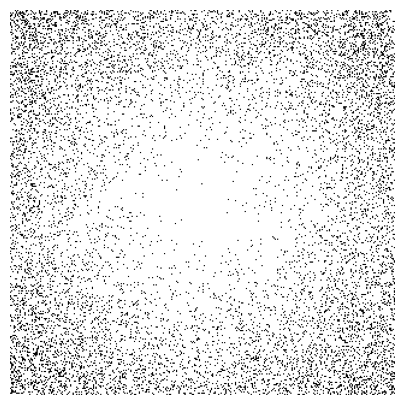

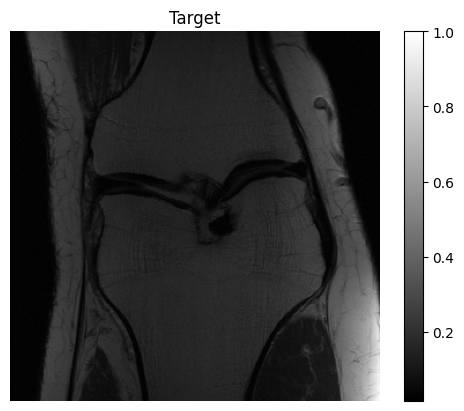

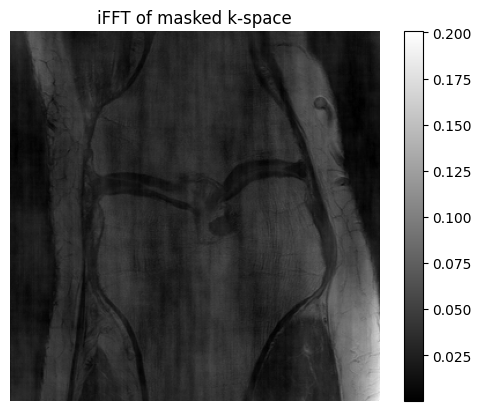

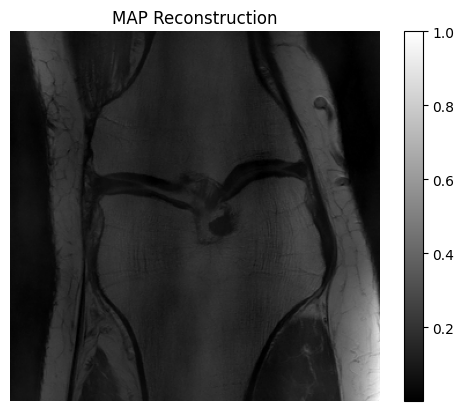

PSNR iFFT: 27.14 dB, NMSE iFFT: 0.0520, SSIM iFFT : 0.8437
None
PSNR MAP: 31.70 dB, NMSE MAP: 0.0182, SSIM MAP: 0.9331
None


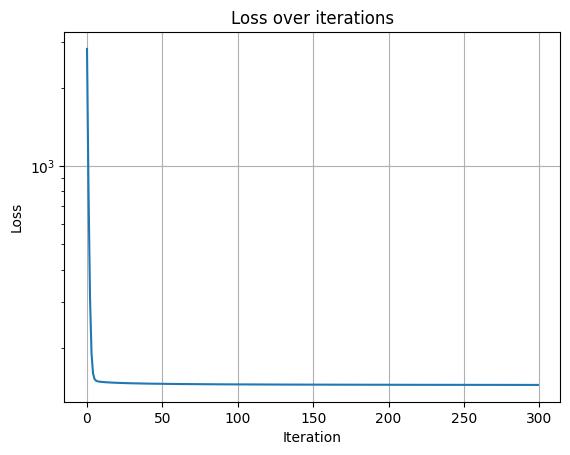

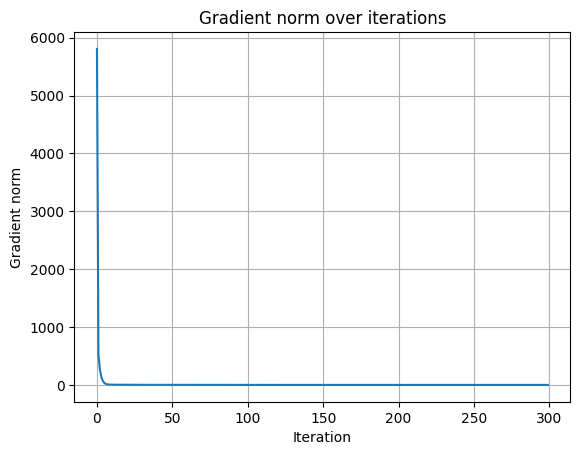

In [ ]:
# MAP diagnostics

import h5py
import numpy as np
import matplotlib.pyplot as plt
from utilities.masks import (
    CenteredBernoulliMask,
    UniformColumnMask,
    VariableDensityMask,
    PseudoRandomColumnMask,
    RadialMask
)
from fastmri.data import transforms as T
from utilities.metrics import psnr, nmse, mean_squared_error, ssim
from MAP.map_tv_minimize import MAPEstimator

# train_dataset, val_dataset, test_dataset = load_fastmri_data(
#     r"C:\Users\kostanjsek\Documents\knee_mri"
# )

file_name = r"C:\Users\jatsok003\file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice
tensor_kspace = T.to_tensor(slice_kspace)

# slice_target = slice_target.astype(np.complex64)
slice_target = slice_target / np.max(np.abs(slice_target))

mask = VariableDensityMask('gaussian', 1.2, seed=30).generate(slice_target.shape)
#mask = PseudoRandomColumnMask(slice_target.shape, 2, 1, seed=30).get_mask()
#mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(slice_target.shape)

y = mask * np.fft.fft2(slice_target, norm='ortho') # mask * slice_kspace
# y = y / np.max(np.abs(y)) #.max()

map_estimator = MAPEstimator(mask, 0.1, 0.1, 1e-2, 1e-2, 300) # default-> (0.1, 0.1, 1e-2, 0.01, 300)
# sigma / np.abs(y).max() ?
map_reconstruct = map_estimator.subgradient_descent(y)

# print(f"target dtype: {slice_target.dtype}")
# print(f"reconstructed image dtype: {map_reconstruct.dtype}")

# mask
plt.figure(figsize=(5, 5))
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#plt.title('Pseudo random (Gaussian 1D)')
plt.axis('off')
plt.show()

# target
plt.imshow(np.abs(slice_target) / np.abs(slice_target.max()), cmap="gray")
plt.title("Target")
plt.colorbar()
plt.axis("off")
plt.show()

# ifft of y for comparison
plt.imshow(np.abs(np.fft.ifft2(y, norm='ortho') / np.abs(np.fft.ifft(y, norm='ortho').max())), cmap="gray")
plt.title("iFFT of masked k-space")
plt.colorbar()
plt.axis("off")
plt.show()

# map reconstruct
plt.imshow(np.abs(map_reconstruct) / np.abs(map_reconstruct.max()) , cmap="gray")
plt.title("MAP Reconstruction")
plt.colorbar()
plt.axis("off")
plt.show()

# metrics

psnr_ifft = psnr(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
nmse_ifft = nmse(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
ssim_ifft = ssim(np.abs(np.fft.ifft2(y, norm='ortho')), slice_target)
print(print(f"PSNR iFFT: {psnr_ifft:.2f} dB, NMSE iFFT: {nmse_ifft:.4f}, SSIM iFFT : {ssim_ifft:.4f}"))

psnr_map = psnr(map_reconstruct, slice_target)
nmse_map = nmse(map_reconstruct, slice_target)
ssim_map = ssim(map_reconstruct, slice_target, data_range=1.0)
print(print(f"PSNR MAP: {psnr_map:.2f} dB, NMSE MAP: {nmse_map:.4f}, SSIM MAP: {ssim_map:.4f}"))


# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()

# print(f"map max value: {np.abs(map_reconstruct).max()}")
# print(f"slice target max value: {np.abs(slice_target).max()}")
# print(slice_target.min(), slice_target.max())
# print(map_reconstruct.min(), map_reconstruct.max())

#print(f"Target diag.: max: {slice_target.max():.3f}, min: {slice_target.min():.3f}, mean: {np.mean(slice_target**2):.3f}, std: {np.std(slice_target):.3f}")


In [6]:
# map diagnsotic tests

import h5py
import numpy as np

from MAP.map_tv_minimize import MAPEstimator
from utilities.masks import VariableDensityMask
from fastmri.data import transforms as T
from utilities.metrics import psnr
from MAP.map_tv_minimize import MAPEstimator
from fastmri.data.mri_data import SliceDataset
from data.load_knee_mri import load_fastmri_data
from MMSE.mmse_ula import MMSEEstimatorULA
from MMSE.mmse_mala import MMSEEstimatorMALA
import skimage as ski

# train_dataset, val_dataset, test_dataset = load_fastmri_data(
#     r"C:\Users\kostanjsek\Documents\knee_mri"
# )

file_name = r"C:\Users\jatsok003\file1000662.h5"
hf = h5py.File(file_name)

volume_kspace = hf['kspace'][()]
target = hf['reconstruction_rss'][()]

slice_kspace = volume_kspace[20]
slice_target = target[20]  # match slice index to kspace slice

mask = VariableDensityMask('gaussian', 0.9, seed=30).generate(slice_target.shape)
map_estimator = MAPEstimator(mask, 0.1, 0.01, 1e-2, 0.01, 300) # def-> 0.95, 0.01, 1e-2, 0.1, 100)

H =320
W =320

def test_adjoint_A(map_estimator, H, W):
    # Adjoint test for A and A*
    x = np.random.randn(H, W) + 1j * np.random.randn(H, W)
    y = np.random.randn(H, W) + 1j * np.random.randn(H, W)

    lhs = np.vdot(map_estimator.A(x), y)
    rhs = np.vdot(x, map_estimator.A_adj(y))

    print("A adjoint test:")
    print("lhs =", lhs)
    print("rhs =", rhs)
    print("difference =", lhs - rhs)
    print()
    # Expected: difference ≈ 1e-13 or smaller.

test_adjoint_A(map_estimator,H,W)

def test_grad_div_adjoint(map_estimator, H, W):
    # Gradient–divergence adjoint test
    x  = np.random.randn(H, W)
    px = np.random.randn(H, W)
    py = np.random.randn(H, W)

    gx, gy = map_estimator.finite_diff_gradient(x)

    lhs = np.sum(gx * px + gy * py)
    rhs = -np.sum(x * map_estimator.divergence(px, py))

    print("grad-div adjoint test:")
    print("lhs =", lhs)
    print("rhs =", rhs)
    print("difference =", lhs - rhs)
    print()
    # Expected: difference ≈ 1e-14.

test_grad_div_adjoint(map_estimator, H,W)

def test_huber_tv_gradient(map_estimator, H, W):
    # Numerical gradient check for Huber-TV
    x = np.random.randn(H, W)

    g = map_estimator.huber_tv_subgradient(x)

    # pick a random perturbation direction
    d = np.random.randn(H, W)

    eps = 1e-6

    # numerical directional derivative
    tv_plus  = map_estimator.huber_tv_2d(x + eps * d)
    tv_minus = map_estimator.huber_tv_2d(x - eps * d)
    num = (tv_plus - tv_minus) / (2 * eps)

    # analytic directional derivative
    ana = np.sum(g * d)

    print("Huber-TV gradient test:")
    print("analytic =", ana)
    print("numeric =", num)
    print("difference =", ana - num)
    print()
    # Expected: difference ≈ 1e-3 to 1e-6. (depends on eps and nondifferentiability)

test_huber_tv_gradient(map_estimator,H,W)

def test_data_fidelity_gradient(map_estimator, H, W):
    # Numerical gradient test for data fidelity
    x = np.random.randn(H, W)
    y = map_estimator.A(x) + 0.01 * (np.random.randn(H, W) + 1j * np.random.randn(H, W))

    g = map_estimator.data_fidelity_gradient(x, y)

    d = np.random.randn(H, W)
    eps = 1e-6

    data_plus  = np.linalg.norm(map_estimator.A(x + eps*d) - y)**2 / (2 * map_estimator.sigma**2)
    data_minus = np.linalg.norm(map_estimator.A(x - eps*d) - y)**2 / (2 * map_estimator.sigma**2)

    num = (data_plus - data_minus) / (2 * eps)
    ana = np.sum(g * d)

    print("Data fidelity gradient test:")
    print("analytic =", ana)
    print("numeric =", num)
    print("difference =", ana - num)
    print()
    # Expected: difference ≈ 1e-7 or better.

test_data_fidelity_gradient(map_estimator,H,W)

def test_full_map_gradient(map_estimator, H, W):
    # Full MAP energy consistency test
    x = np.random.randn(H, W)
    y = map_estimator.A(x) + 0.01 * (np.random.randn(H, W) + 1j * 
                                     np.random.randn(H, W))

    grad_data = map_estimator.data_fidelity_gradient(x, y)
    grad_tv   = map_estimator.huber_tv_subgradient(x)
    g = grad_data + map_estimator.lambda_ * grad_tv

    d = np.random.randn(H, W)
    eps = 5e-6

    Eplus  = map_estimator.compute_loss(x + eps*d, y)
    Eminus = map_estimator.compute_loss(x - eps*d, y)

    num = (Eplus - Eminus) / (2*eps)
    ana = np.sum(g * d)

    print("Full MAP gradient test:")
    print("analytic =", ana)
    print("numeric =", num)
    print("difference =", ana - num)
    print()
    # Expected: difference ≈ 1e-6 or lower.

test_full_map_gradient(map_estimator, H, W)

A adjoint test:
lhs = (83.51985270282518-28.264824184284805j)
rhs = (83.51985270282537-28.264824184284805j)
difference = (-1.9895196601282805e-13+0j)

grad-div adjoint test:
lhs = 583.0560210186114
rhs = 583.0560210186119
difference = -4.547473508864641e-13

Huber-TV gradient test:
analytic = 593.5563719557637
numeric = 593.5563676757738
difference = 4.279989866518008e-06

Data fidelity gradient test:
analytic = 465.7118903851261
numeric = 465.7118910245117
difference = -6.39385632439371e-07

Full MAP gradient test:
analytic = 100.05007758715072
numeric = 100.05007766267225
difference = -7.552152681000734e-08

